In [1]:
import torch
import os
import random
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torchsummary
from matplotlib import pyplot as plt
from skimage.io import imread
from tqdm import tqdm

In [2]:
# path = '../data/spectrograms/test/'
# for img in os.listdir(path):
#     size = imread(f'{path}{img}').shape[1]
#     if size != 1248:
#         print(size, img)

In [3]:
torch.cuda.is_available()

True

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.deterministic = True

In [6]:
train_dir = '../data/spectrograms/train/train/'
val_dir = '../data/spectrograms/train/val/'
test_dir = '../data/spectrograms/test/'

In [7]:
one_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.0069], [0.0033])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, one_transform)
val_dataset = torchvision.datasets.ImageFolder(val_dir, one_transform)

batch_size = 4
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=8
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=8
)

class_names = train_dataset.classes

In [8]:
for x, y in train_dataloader:
    x.to(device)
    y.to(device)
    break

In [9]:
# N_CHANNELS = 1
# mean = torch.zeros(1)
# std = torch.zeros(1)
# print('==> Computing mean and std..')
# for inputs, _labels in train_dataloader:
#     for i in range(N_CHANNELS):
#         mean[i] += inputs[:,i,:,:].mean()
#         std[i] += inputs[:,i,:,:].std()
# mean.div_(len(train_dataset))
# std.div_(len(train_dataset))
# print(mean, std)

In [10]:
len(train_dataloader), len(train_dataset)

(1776, 7107)

In [11]:
len(val_dataloader), len(val_dataset)

(198, 790)

In [12]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy()
    mean = np.array([0.0069])
    std = np.array([0.0033])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1).transpose((1, 2, 0))
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

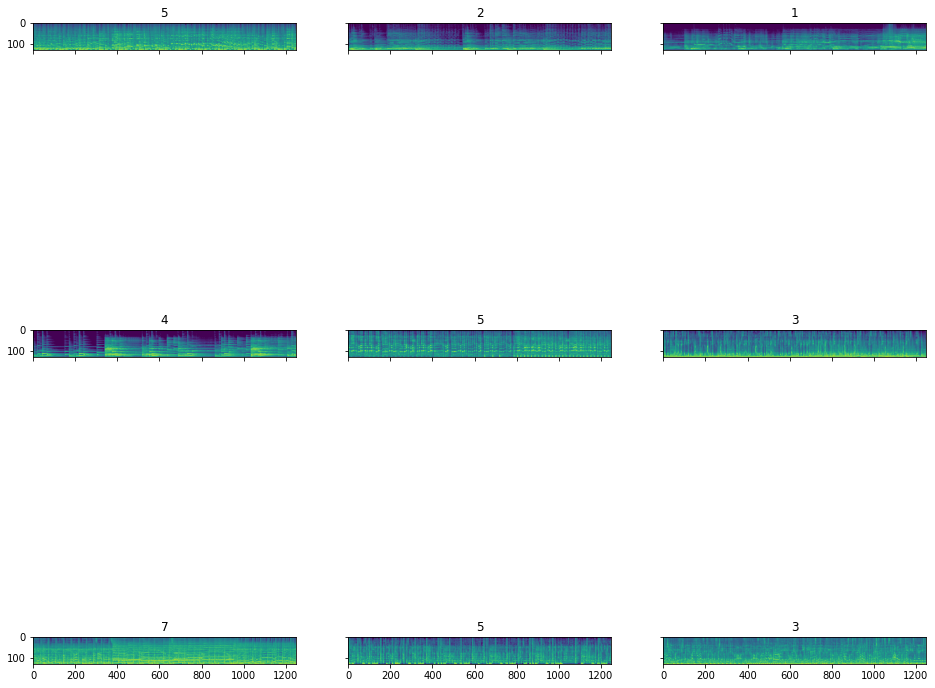

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(16, 16), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,len(val_dataset)))
    im_val, label = val_dataset[random_characters]
#     img_label = " ".join(map(lambda x: x.capitalize(),\
#                 val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=label,plt_ax=fig_x)

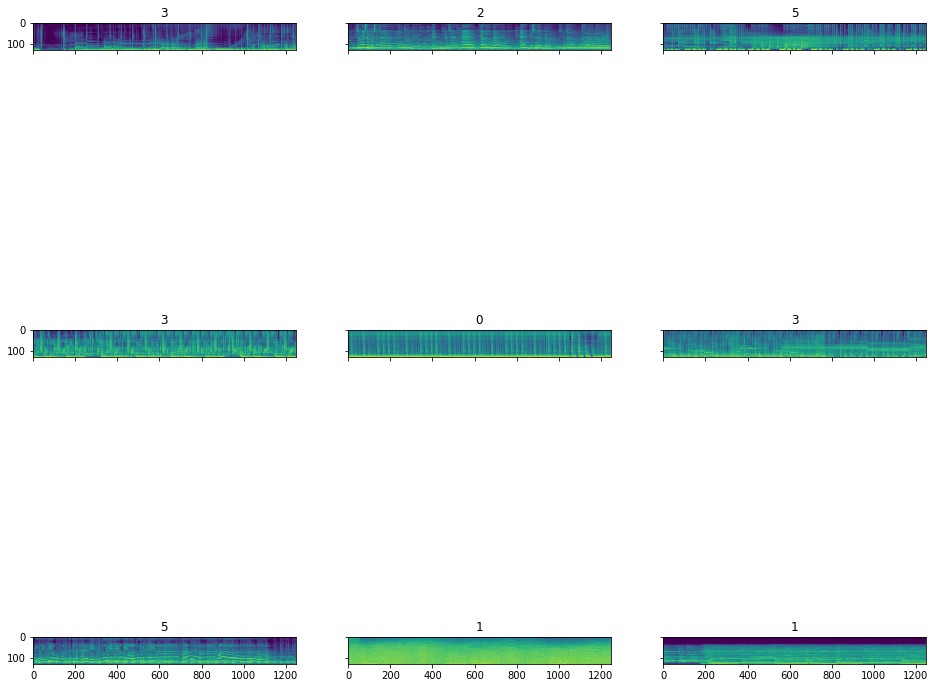

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(16, 16), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,len(train_dataset)))
    im_train, label = train_dataset[random_characters]
#     img_label = " ".join(map(lambda x: x.capitalize(),\
#                 val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_train.data.cpu(), title=label,plt_ax=fig_x)

In [15]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [16]:
model = torch.nn.Sequential()

# dense "head"
model.add_module('conv1', torch.nn.Conv2d(1, 128, 3, padding=1))
model.add_module('bn1', torch.nn.BatchNorm2d(128))
model.add_module('conv1_relu', torch.nn.ReLU())
model.add_module('pool_1', torch.nn.MaxPool2d((2, 4)))
model.add_module('drop_1', torch.nn.Dropout2d())

model.add_module('conv2', torch.nn.Conv2d(128, 384, 3, padding=1))
model.add_module('bn2', torch.nn.BatchNorm2d(384))
model.add_module('conv2_relu', torch.nn.ReLU())
model.add_module('pool_2', torch.nn.MaxPool2d((2, 4)))
model.add_module('drop_2', torch.nn.Dropout2d())

model.add_module('conv3', torch.nn.Conv2d(384, 768, 3, padding=1))
model.add_module('bn3', torch.nn.BatchNorm2d(768))
model.add_module('conv3_relu', torch.nn.ReLU())
model.add_module('pool_3', torch.nn.MaxPool2d((2, 4)))
model.add_module('drop_3', torch.nn.Dropout2d())

model.add_module('conv4', torch.nn.Conv2d(768, 2048, 3, padding=1))
model.add_module('bn4', torch.nn.BatchNorm2d(2048))
model.add_module('conv4_relu', torch.nn.ReLU())
model.add_module('pool_4', torch.nn.MaxPool2d(16, 19))
model.add_module('drop_4', torch.nn.Dropout2d())

model.add_module('flat', Flatten())
model.add_module('dense', torch.nn.Linear(2048, 8))
model.add_module('sigm', torch.nn.Sigmoid())

In [17]:
# model

In [18]:
# torchsummary.summary(model.cuda(), (1, 128, 1248))

In [19]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outs = model(inputs)
        loss = criterion(outs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [20]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outs = model(inputs)
            loss = criterion(outs, labels)
            preds = torch.argmax(outs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [21]:
def train(train_loader, val_loader, model, epochs, optimizer, criterion, scheduler):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            scheduler.step()
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [47]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs, x, path in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = torch.nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [23]:
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

In [24]:
history = train(train_dataloader, val_dataloader, model=model, epochs=5, optimizer=optimizer, criterion=criterion, scheduler=scheduler)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 2.0300325224394196


epoch:  20%|██        | 1/5 [12:21<49:27, 741.81s/it]


Epoch 001 train_loss: 2.0300     val_loss 1.9581 train_acc 0.1964 val_acc 0.2241
loss 1.8750059468386409


epoch:  40%|████      | 2/5 [24:08<36:33, 731.28s/it]


Epoch 002 train_loss: 1.8750     val_loss 1.8312 train_acc 0.3038 val_acc 0.3316
loss 1.7891761235691406


epoch:  60%|██████    | 3/5 [35:54<24:07, 723.57s/it]


Epoch 003 train_loss: 1.7892     val_loss 1.7770 train_acc 0.4003 val_acc 0.4367
loss 1.7542227935549375


epoch:  80%|████████  | 4/5 [47:54<12:02, 722.74s/it]


Epoch 004 train_loss: 1.7542     val_loss 1.7617 train_acc 0.4452 val_acc 0.4329
loss 1.706857992990597


epoch: 100%|██████████| 5/5 [59:54<00:00, 718.85s/it]


Epoch 005 train_loss: 1.7069     val_loss 1.7216 train_acc 0.4987 val_acc 0.4481


In [25]:
loss, acc, val_loss, val_acc = zip(*history)

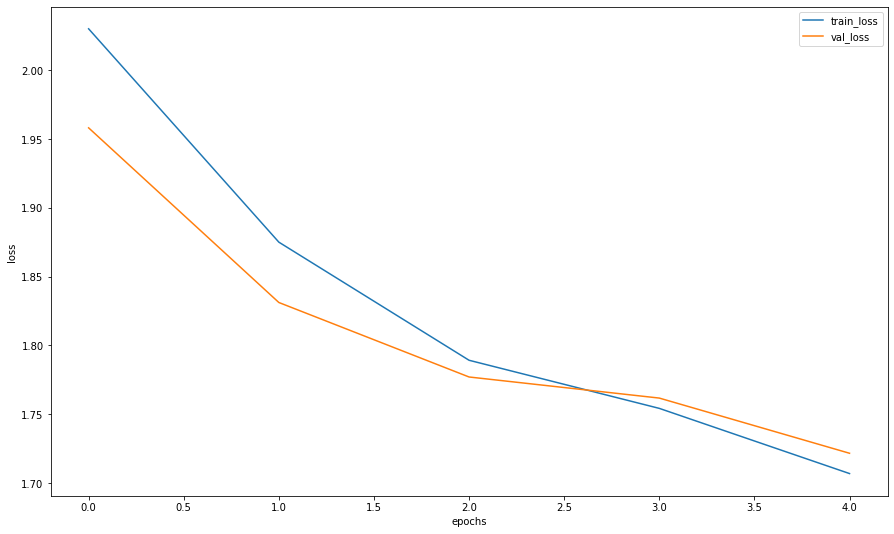

In [26]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

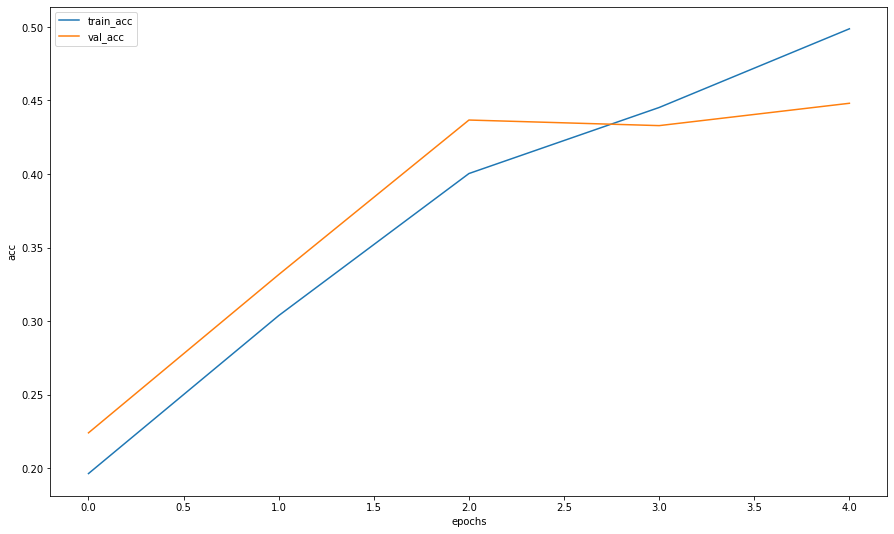

In [27]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

In [28]:
import pickle
with open('../data/pickles/models/25_11.pickle', 'wb') as f:
    pickle.dump(model, f)

In [64]:
with open('../data/pickles/main_dict.pickle', 'rb') as f:
    main_dict = pickle.load(f)

In [44]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [45]:
test_dataset = ImageFolderWithPaths(test_dir, one_transform)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=8
)

In [59]:
probs = predict(model, test_dataloader)

In [60]:
preds = np.argmax(probs, axis=1)

In [61]:
preds = [class_names[x]for x in preds]

In [65]:
true_class = list()
for x in test_dataset:
    path = x[2]
    name = path.split('/')[5].strip('.png')
    genre = main_dict[int(name)]['genre']
    true_class.append(genre)

In [74]:
np.array(np.array(true_class) == np.array(preds)).sum() / len(preds)

0.4020618556701031

In [38]:
class_names

['Electronic',
 'Experimental',
 'Folk',
 'Hip-Hop',
 'Instrumental',
 'International',
 'Pop',
 'Rock']

In [75]:
test_dataset[0][2]

'../data/spectrograms/test/unknown/000190.png'